<a href="https://colab.research.google.com/github/mukkatharun/GradientBoostMethods/blob/main/gradient_boost_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install lightgbm

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn import tree
import lightgbm as lgb

In [3]:
data = pd.read_csv('b_cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
data['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [6]:
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})
data.shape

(569, 33)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


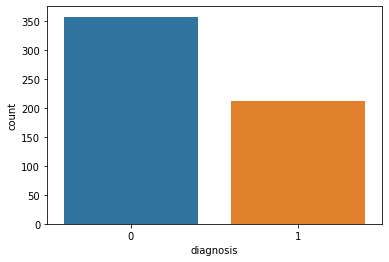

In [7]:
sns.countplot(data['diagnosis'],label="Count")

In [8]:
requiredData= list(data.columns[1:11])

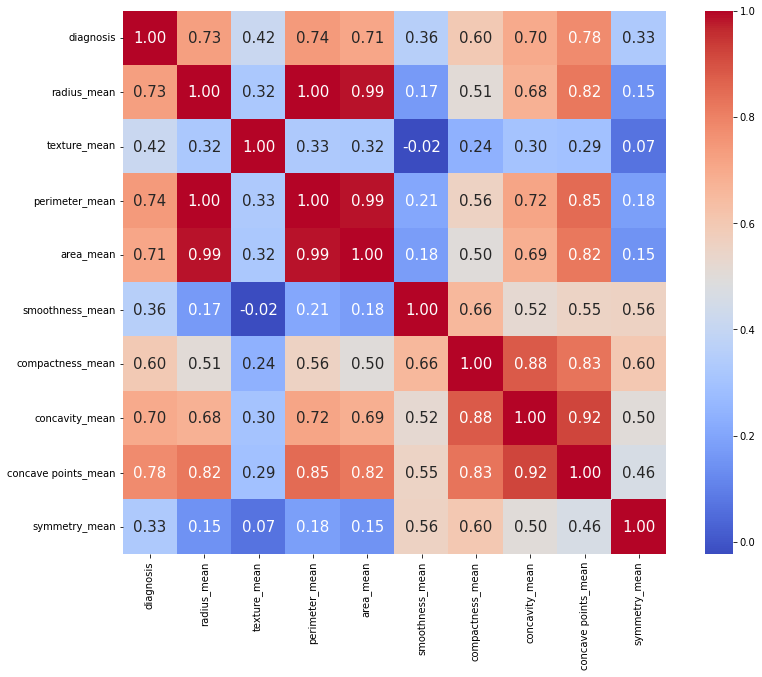

In [9]:
#Using the correlation matrix to find the features that affect the target value
corr = data[requiredData].corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= requiredData, yticklabels= requiredData,
           cmap= 'coolwarm')

In [10]:
# after analysing the matrix, only 5 parameters are highly correlated to diagnosis
df = data[['texture_mean','perimeter_mean','smoothness_mean','compactness_mean','symmetry_mean','diagnosis']]
df = df.dropna()

In [11]:
df.isna().count()

texture_mean        569
perimeter_mean      569
smoothness_mean     569
compactness_mean    569
symmetry_mean       569
diagnosis           569
dtype: int64

In [12]:
features = df[['texture_mean','perimeter_mean','smoothness_mean','compactness_mean','symmetry_mean']]
diagnosis = df[['diagnosis']]
print(features.shape, diagnosis.shape)

(569, 5) (569, 1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(512, 5) (57, 5) (512, 1) (57, 1)


In [14]:
features.head()

,texture_mean,perimeter_mean,smoothness_mean,compactness_mean,symmetry_mean
0,10.38,122.80,0.11840,0.27760,0.2419
1,17.77,132.90,0.08474,0.07864,0.1812
2,21.25,130.00,0.10960,0.15990,0.2069
3,20.38,77.58,0.14250,0.28390,0.2597
4,14.34,135.10,0.10030,0.13280,0.1809


XGBoost

In [15]:
model = XGBClassifier(n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
model.fit(X_train, y_train)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.934 (0.043)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
testRow = X_test.iloc[1].to_numpy()
testRow

array([14.93   , 73.87   ,  0.1013 ,  0.07808,  0.1883 ])

In [17]:
model.predict(X_test.head(1))

array([1])

CatBoost

In [18]:
# evaluate the model
catModel = CatBoostClassifier(verbose=0, n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
catModel.fit(X_train, y_train)
n_scores = cross_val_score(catModel, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.926 (0.041)


In [19]:
test = [[14.44,74.65,0.09984,0.112,0.1818]]
test

[[14.44, 74.65, 0.09984, 0.112, 0.1818]]

In [20]:
catModel.predict(X_test.head(1))

array([1])

LightGBM

In [21]:
LGBMModel = LGBMClassifier(n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
LGBMModel.fit(X_train, y_train)
n_scores = cross_val_score(LGBMModel, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.928 (0.042)


In [22]:
LGBMModel.predict(X_test.head(1))

array([1])

AdaBoost

In [23]:
ABmodel = AdaBoostClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
ABmodel.fit(X_train, y_train)
n_scores = cross_val_score(ABmodel, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.928 (0.039)


In [24]:
ABmodel.predict(X_test.head(1))

array([1])

Decision Tree

In [25]:
DTModel = tree.DecisionTreeClassifier()
DTModel.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
DTModel.predict(X_test.head(1))

array([1])

Regression

XGBoost

In [27]:
XGBmodel = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
XGBmodel.fit(X_train, y_train)
n_scores = cross_val_score(XGBmodel, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


MAE: -0.135 (0.023)


In [28]:
XGBmodel.predict(X_test.head(1))

array([0.9391012], dtype=float32)

CatBoost

In [29]:
catRModel = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
catRModel.fit(X_train, y_train)
n_scores = cross_val_score(catRModel, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


MAE: -0.136 (0.024)


LightGBM

In [30]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
model.fit(X_train, y_train)
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


MAE: -0.139 (0.025)


Ranking

LightGBM

In [32]:
gbm = lgb.LGBMRanker()

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [35]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
print(query_train, query_val, query_test)

[409] [103] [57]


In [36]:
gbm.fit(X_train, y_train, group=query_train,
        eval_set=[(X_val, y_val)], eval_group=[query_val],
        eval_at=[5, 10, 20], early_stopping_rounds=50)

[1]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[3]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[4]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[5]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[6]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[7]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[8]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[9]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[10]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[11]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[12]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[13]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[14]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[15]	vali

LGBMRanker()

In [38]:
test_pred = gbm.predict(X_test)
test_pred

array([ 0.05      , -0.05      ,  0.00093253, -0.05      , -0.05      ,
       -0.05      ,  0.02136856,  0.00093253,  0.05      ,  0.05      ,
        0.00093253,  0.0471285 ,  0.02136856, -0.0420813 ,  0.0257262 ,
        0.03877201,  0.0471285 , -0.05      , -0.05      ,  0.05      ,
       -0.05      ,  0.02136856,  0.05      , -0.04366165, -0.04101504,
       -0.05      , -0.04366165, -0.04101504, -0.05      , -0.04366165,
       -0.0420813 ,  0.00093253, -0.05      , -0.05      ,  0.03877201,
       -0.05      , -0.05      ,  0.00093253,  0.0471285 , -0.04101504,
       -0.05      ,  0.05      , -0.04101504, -0.04101504,  0.05      ,
       -0.05      , -0.05      , -0.04101504, -0.05      ,  0.05      ,
        0.05      , -0.05      ,  0.05      , -0.04366165,  0.0257262 ,
        0.05      ,  0.00093253])

In [40]:
X_test["predicted_ranking"] = test_pred
X_test.sort_values("predicted_ranking", ascending=False)
X_test.head()

,texture_mean,perimeter_mean,smoothness_mean,compactness_mean,symmetry_mean,predicted_ranking
65,23.94,97.40,0.11720,0.14790,0.1953,0.050000
249,14.93,73.87,0.10130,0.07808,0.1883,-0.050000
415,21.17,76.39,0.09773,0.08120,0.2019,0.000933
154,15.34,85.31,0.09384,0.08498,0.1822,-0.050000
381,14.93,70.67,0.07987,0.07079,0.2003,-0.050000
